![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [62]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [65]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### librerías

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

Mejor umbral para 'Year': 2012
RMSE en el set de prueba: 2552.27
MAE en el set de prueba: 1977.61


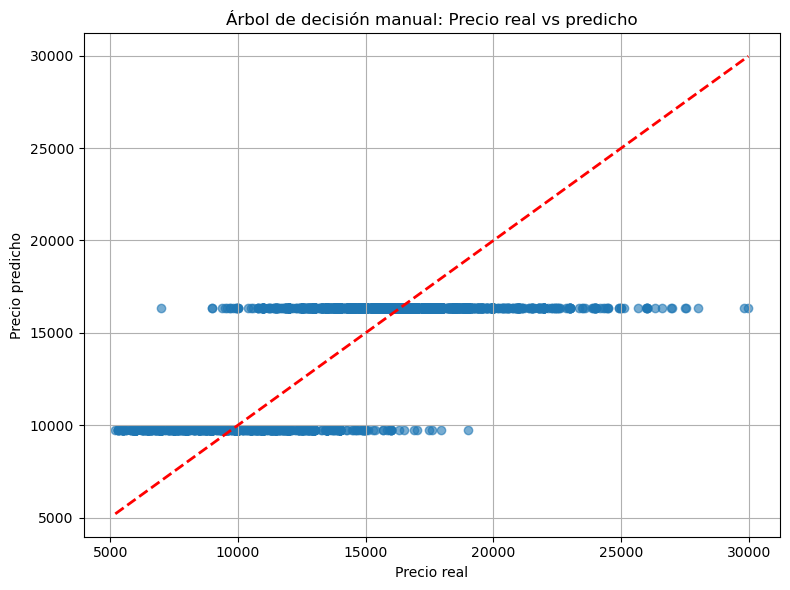

In [122]:
thresholds = sorted(X_train['Year'].unique())
best_rmse = float('inf')
best_threshold = None

for t in thresholds:
    left_mask = X_train['Year'] <= t
    right_mask = ~left_mask

    y_pred_train = np.where(left_mask, y_train[left_mask].mean(), y_train[right_mask].mean())
    rmse = mean_squared_error(y_train, y_pred_train)

    if rmse < best_rmse:
        best_rmse = rmse
        best_threshold = t


left_mean = y_train[X_train['Year'] <= best_threshold].mean()
right_mean = y_train[X_train['Year'] > best_threshold].mean()
y_pred_test = np.where(X_test['Year'] <= best_threshold, left_mean, right_mean)


rmse_test = root_mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)


print(f"Mejor umbral para 'Year': {best_threshold}")
print(f"RMSE en el set de prueba: {rmse_test:.2f}")
print(f"MAE en el set de prueba: {mae_test:.2f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Árbol de decisión manual: Precio real vs predicho")
plt.grid(True)
plt.tight_layout()
plt.show()


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2 DANI

predictions = []
oob_errors = []  

for _ in range(10):
    
    idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[idx]
    y_bootstrap = y_train.iloc[idx]

    
    mask = ~X_train.index.isin(idx)
    X_oob = X_train.loc[mask]
    y_oob = y_train.loc[mask]

    
    model = pipeline_base.fit(X_bootstrap, y_bootstrap)

    
    preds = model.predict(X_test)
    predictions.append(preds)

    
    if not X_oob.empty:
        oob_pred = model.predict(X_oob)
        oob_error = mean_squared_error(y_oob, oob_pred)
        oob_errors.append(oob_error)


y_pred_manual_bagging = np.mean(predictions, axis=0)


mae_2 = mean_absolute_error(y_test, y_pred_manual_bagging)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_manual_bagging))
r2_2 = r2_score(y_test, y_pred_manual_bagging)


oob_error_mean = np.mean(oob_errors)


print("Punto 2 - Bagging Manual")
print(f"MAE: {mae_2:.2f}")
print(f"RMSE: {rmse_2:.2f}")
print(f"R²: {r2_2:.3f}")
print(f"Error OOB (promedio MSE): {oob_error_mean:.2f}") 

Punto 2 - Bagging Manual
MAE: 2411.03
RMSE: 3864.99
R²: 0.870
Error OOB (promedio MSE): 8763264.11


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

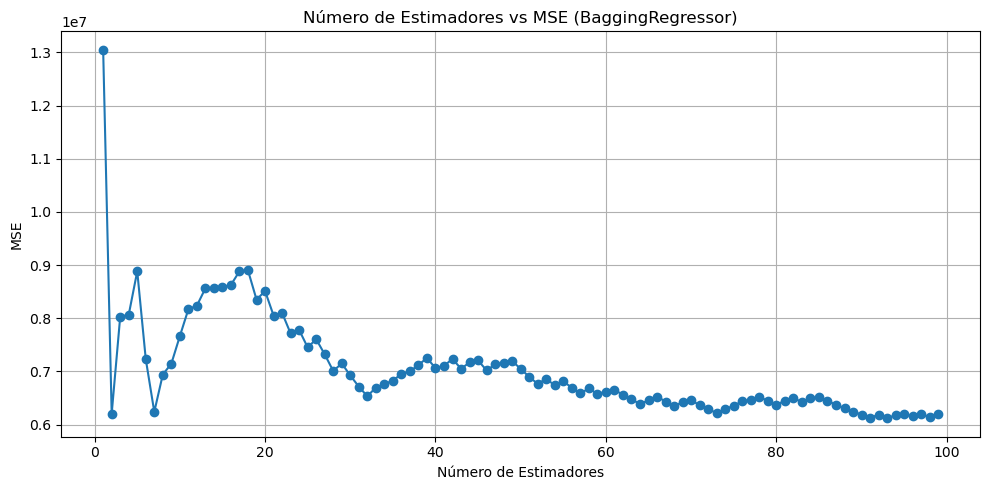

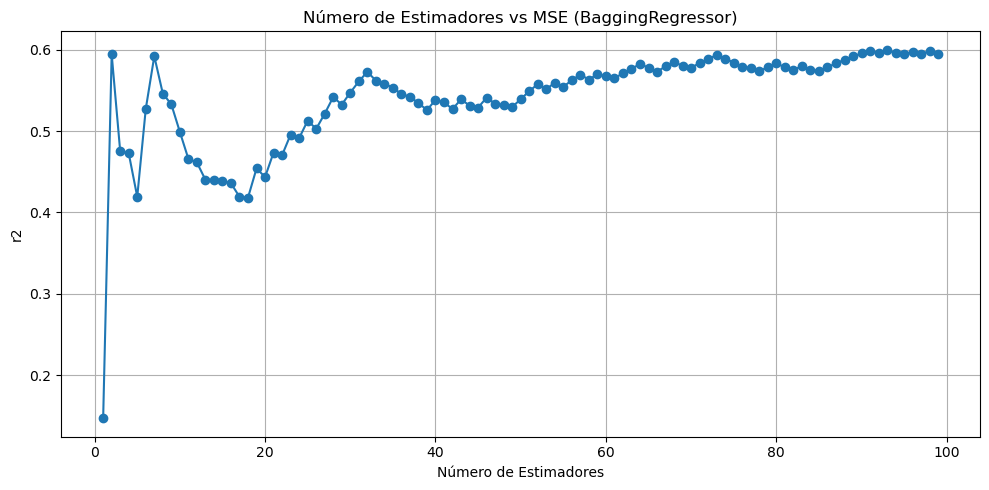

Resultados modelo final optimizado
Mejor número de estimadores: 93
MAE: 1904.71
RMSE: 2473.86
R²: 0.600


In [87]:
# Celda 3 DANI
n_features = X_train.shape[1]
max_features_log = int(log(n_features))


mse_list = []
r2_list = []
n_estimators_range = range(1, 100)

for n in n_estimators_range:
    model = BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        n_estimators=n,
        max_features=max_features_log,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)


optimal_n = n_estimators_range[np.argmin(mse_list)]


plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, mse_list, marker='o')
plt.title('Número de Estimadores vs MSE (BaggingRegressor)')
plt.xlabel('Número de Estimadores')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()

for n in n_estimators_range:
    model = BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        n_estimators=n,
        max_features=max_features_log,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)


optimal_n_r2 = n_estimators_range[np.argmin(r2_list)]
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, r2_list, marker='o')
plt.title('Número de Estimadores vs MSE (BaggingRegressor)')
plt.xlabel('Número de Estimadores')
plt.ylabel('r2')
plt.grid(True)
plt.tight_layout()
plt.show()

best_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    n_estimators=optimal_n,
    max_features=max_features_log,
    random_state=42
)

best_model.fit(X_train, y_train)
y_pred_final = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)

print("Resultados modelo final optimizado")
print(f"Mejor número de estimadores: {optimal_n}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [7]:
# Celda 4 ANGEL
# Entrenamiento del modelo
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predicciones sobre el set de prueba
y_pred = clf.predict(X_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Evaluación del modelo Random Forest en el conjunto de prueba:")
print(f"MAE (Error absoluto medio): {mae:,.2f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:,.2f}")
print(f"R² (Coeficiente de determinación): {r2:.4f}")

# Evaluación con validación cruzada
cv_scores = cross_val_score(clf, X, y, cv=10, scoring='r2')
print(pd.Series(cv_scores).describe())


Evaluación del modelo Random Forest en el conjunto de prueba:
MAE (Error absoluto medio): 1,314.42
RMSE (Raíz del error cuadrático medio): 1,765.41
R² (Coeficiente de determinación): 0.7962
count    10.000000
mean      0.800932
std       0.010974
min       0.781114
25%       0.795818
50%       0.803186
75%       0.806421
max       0.815884
dtype: float64


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

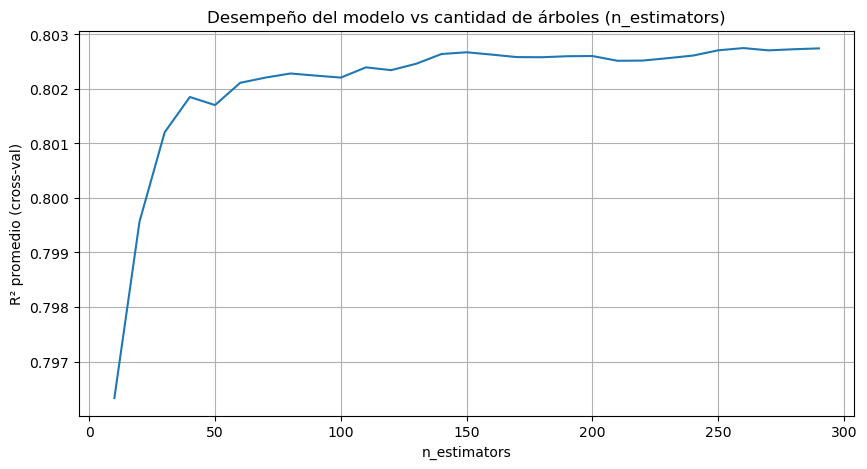

In [8]:
# Celda 5 ANGEL
# Lista de columnas predictoras
feature_cols = X.columns

# Gráfica para n_estimators (cantidad de árboles)
estimator_range = range(10, 300, 10)
r2_scores_estimators = []

for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
    r2_scores_estimators.append(scores.mean())

# Graficar resultados para n_estimators
plt.figure(figsize=(10, 5))
plt.plot(estimator_range, r2_scores_estimators)
plt.xlabel('n_estimators')
plt.ylabel('R² promedio (cross-val)')
plt.title('Desempeño del modelo vs cantidad de árboles (n_estimators)')
plt.grid(True)
plt.show()

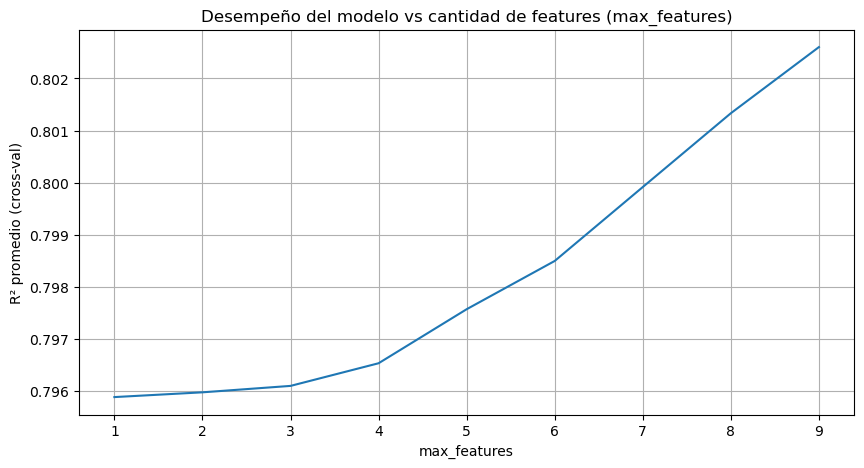

In [20]:
 # Gráfica para max_features (cantidad de variables por árbol)
feature_range = range(1, len(feature_cols) + 1)
r2_scores_features = []

for feature in feature_range:
    rf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
    r2_scores_features.append(scores.mean())

# Graficar resultados para max_features
plt.figure(figsize=(10, 5))
plt.plot(feature_range, r2_scores_features)
plt.xlabel('max_features')
plt.ylabel('R² promedio (cross-val)')
plt.title('Desempeño del modelo vs cantidad de features (max_features)')
plt.grid(True)
plt.show()

In [9]:
# Entrenamiento del modelo con hiperparámetros calibrados
clf = RandomForestRegressor(n_estimators=150, max_features=9, random_state=1, n_jobs=-1)
clf.fit(X, y)

# Importancia de las variables
feature_cols = X.columns  # Si no está definido antes, esta línea lo asegura
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

# Mostrar importancia de las variables
print("Importancia de características con max_features=9 y n_estimators=150:")
print(importances)


Importancia de características con max_features=9 y n_estimators=150:
       feature  importance
0         Year    0.706140
1      Mileage    0.255212
8   M_CamryXLE    0.014924
6    M_CamryLE    0.009657
2      M_Camry    0.006470
7    M_CamrySE    0.004839
5     M_CamryL    0.001196
3   M_Camry4dr    0.001080
4  M_CamryBase    0.000482


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [136]:
# Celda 6
#Importación XGBRegressor
# Definición del modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=123)
# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)
# Predicciones
y_xgb_pred = xgb_model.predict(X_test)
# Evaluación del modelo sin optimización de hiperparámetros
xgb_rmse = root_mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)
xgb_mae = mean_absolute_error(y_test, y_pred_test)
print(f"RMSE: {xgb_rmse:.3f}")
print(f"MAE:{xgb_mae:.2f}")
print(f"r2:{xgb_r2:.2f}")

RMSE: 1605.235
MAE:1977.61
r2:0.83


# Interpretación XGBoost
El modelo entrenado carece de interpretabilidad en el planteamiento debido a su naturaleza de modelo caja negra, en cuanto a los resultados se obtiene un error cuadrado medio menor a los modelos previamente entrenados a costa de una degradación del rendimiento en cuanto al r2 lo que puede indicar una optimización en el sobreajuste y una predicción más acertada

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

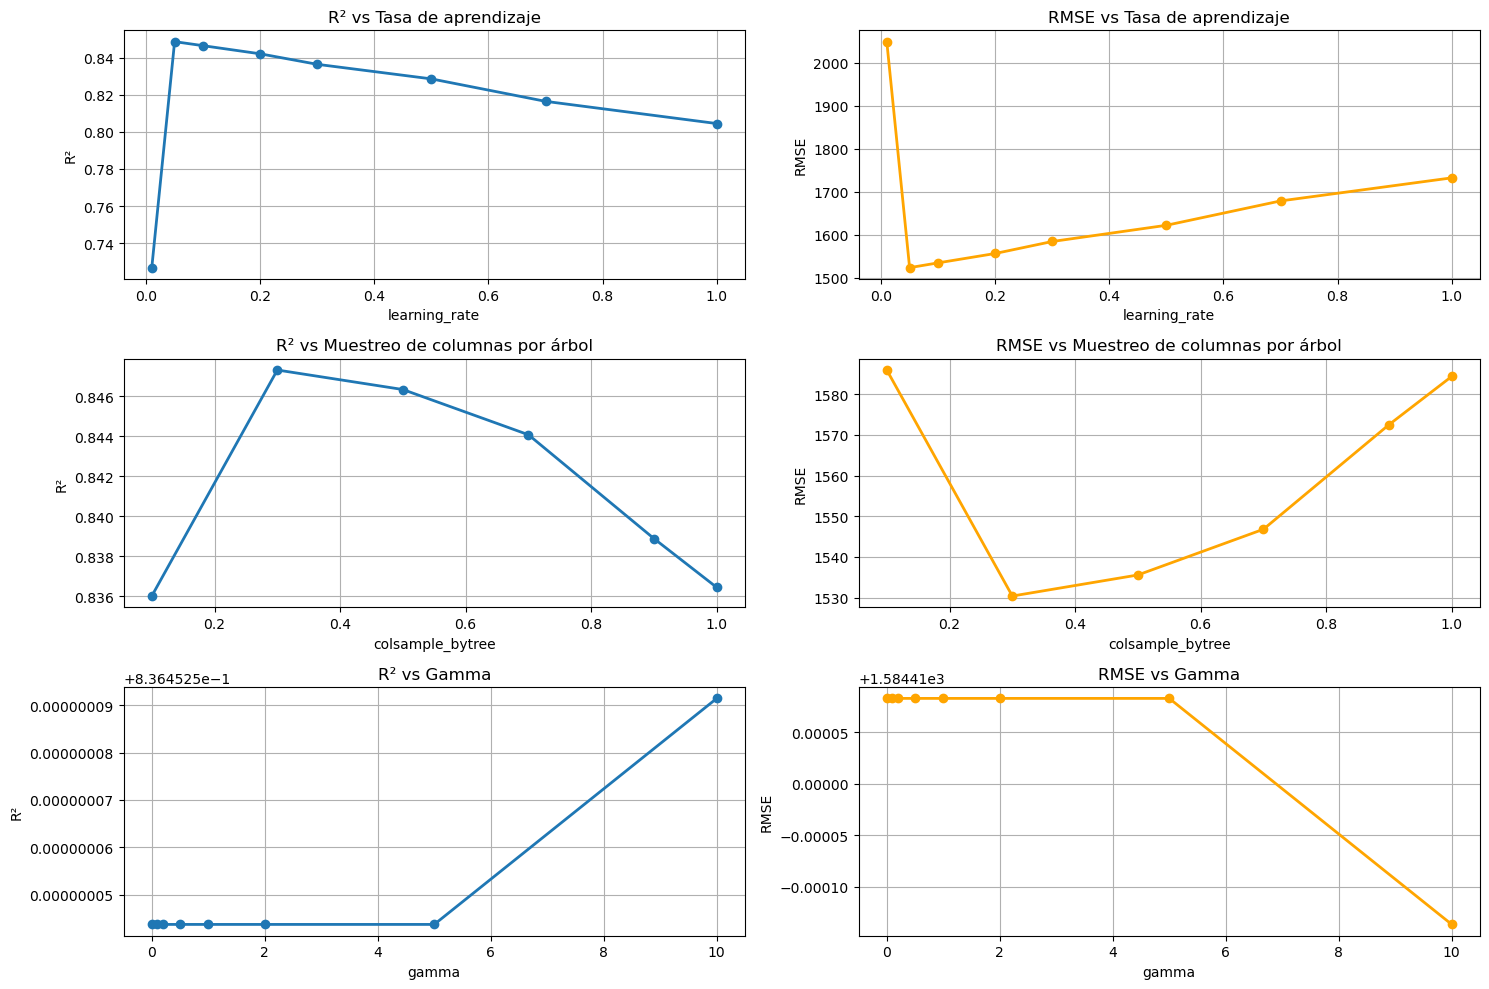

Mejor learning_rate: 0.05 (R²: 0.8487, RMSE: 1523.58), MAE: 1118.31)
Mejor colsample_bytree: 0.3 (R²: 0.8473, RMSE: 1530.37), MAE: 1128.56)
Mejor gamma: 10 (R²: 0.8365, RMSE: 1584.41), MAE: 1165.39)


In [138]:
learning_rate_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
colsample_bytree_range = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
gamma_range = [0, 0.1, 0.2, 0.5, 1, 2, 5, 10]
# Configuración común
n_estimators = 100
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}
# Función para evaluar hiperparámetros con métricas directas de sklearn
def evaluate_param(param_name, param_range):
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    for hyperparam in param_range:
        # Configurar modelo con el valor del parámetro actual
        params = {
            'n_estimators': n_estimators,
            param_name: hyperparam
        }
        fold_r2s = []
        fold_rmses = []
        fold_maes = []
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            # Entrenar modelo
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train)
            # Predecir
            y_pred = model.predict(X_test)
            # Calcular métricas directamente
            fold_r2 = r2_score(y_test, y_pred)
            fold_rmse = root_mean_squared_error(y_test, y_pred)
            fold_mae = mean_absolute_error(y_test, y_pred)
            fold_r2s.append(fold_r2)
            fold_rmses.append(fold_rmse)
            fold_maes.append(fold_mae)
        # Promediar métricas de todos los folds
        r2_scores.append(np.mean(fold_r2s))
        rmse_scores.append(np.mean(fold_rmses))
        mae_scores.append(np.mean(fold_maes))
    # Encontrar mejor valor (mejor R²)
    best_idx = np.argmax(r2_scores)
    best_value = param_range[best_idx]
    return {
        'param_range': param_range,
        'r2_scores': r2_scores,
        'rmse_scores': rmse_scores,
        'mae_scores':mae_scores,
        'best_value': best_value,
        'best_r2': r2_scores[best_idx],
        'best_rmse': rmse_scores[best_idx],
        'best_mae': mae_scores[best_idx]
    }
# Evaluar cada hiperparámetro
results['learning_rate'] = evaluate_param('learning_rate', learning_rate_range)
results['colsample_bytree'] = evaluate_param('colsample_bytree', colsample_bytree_range)
results['gamma'] = evaluate_param('gamma', gamma_range)
# Crear gráficas
plt.figure(figsize=(15, 10))
param_names = ['learning_rate', 'colsample_bytree', 'gamma']
titles = ['Tasa de aprendizaje', 'Muestreo de columnas por árbol', 'Gamma']
for i, param in enumerate(param_names):
    # Gráfico R²
    plt.subplot(3, 2, i*2+1)
    plt.plot(results[param]['param_range'], results[param]['r2_scores'], 'o-', linewidth=2)
    plt.title(f'R² vs {titles[i]}')
    plt.xlabel(param)
    plt.ylabel('R²')
    plt.ticklabel_format(style='plain')
    plt.grid(True)
    # Gráfico RMSE
    plt.subplot(3, 2, i*2+2)
    plt.plot(results[param]['param_range'], results[param]['rmse_scores'], 'o-', color='orange', linewidth=2)
    plt.title(f'RMSE vs {titles[i]}')
    plt.xlabel(param)
    plt.ylabel('RMSE')
    plt.ticklabel_format(style='plain')
    plt.grid(True)
plt.tight_layout()
plt.show()
for param in param_names:
    print(f"Mejor {param}: {results[param]['best_value']} (R²: {results[param]['best_r2']:.4f}, RMSE: {results[param]['best_rmse']:.2f}), MAE: {results[param]['best_mae']:.2f})")

In [126]:
print(f'max_r2_learning_rate:{max(results["learning_rate"]["r2_scores"])} min_r2_learning_rate:{min(results["learning_rate"]["r2_scores"])}')

max_r2_learning_rate:0.8486911058425903 min_r2_learning_rate:0.7267664313316345


In [128]:
print(f'max_r2_rmse_scores:{max(results["learning_rate"]["rmse_scores"])} min_r2_learning_rate:{min(results["learning_rate"]["rmse_scores"])}')

max_r2_rmse_scores:2049.0612060546873 min_r2_learning_rate:1523.57705078125


In [130]:
print(f'max_r2_gamma:{max(results["gamma"]["r2_scores"])} min_r2_gamma:{min(results["gamma"]["r2_scores"])}')

max_r2_gamma:0.83645259141922 min_r2_gamma:0.8364525437355042


In [132]:
print(f'max_rmse_gamma:{max(results["gamma"]["rmse_scores"])} min_rmse_gamma:{min(results["gamma"]["rmse_scores"])}')

max_rmse_gamma:1584.4100830078125 min_rmse_gamma:1584.40986328125


# Interpretación sobre los resultados
Los hiperparámetros calibrados por método analítico (cálculo de valor máximo de hiperparámetros) demuestran que los mejores valores para cada caso son:
- Mejor learning_rate = 0.05 con (R²: 0.8487, RMSE: 1523.58)
- Mejor colsample_bytree = 0.3 con (R²: 0.8473, RMSE: 1530.37)
- Mejor gamma= 10 con (R²: 0.8365, RMSE: 1584.41)

A partir de las gráficas generadas, podemos evidenciar que el parámetro más sensible es tasa de aprendizaje (learning_rate) con rangos de (0.73 y 0.85 para R2) y (2049 a 1523 para RMSE) respectivamente. El muestreo de columnas por árbol (colsample_bytree) y gamma parecen no representar una diferencia tan significativa en el rendimiento del modelo a lo largo de sus posibles valores.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

Se comenzó evaluando un modelo de árbol de decisión manual, en el cual se determinó un umbral óptimo para la variable 'Year' en 2012. Este modelo simple que divide los datos en dos grupos según el año del vehículo, obtuvo un RMSE de 2,552.27 y un MAE de 1,977.61 en el conjunto de prueba. Aunque su estructura es básica, el modelo logró capturar parte importante de la variabilidad en los precios siendo un buen scenario base.

Posteriormente, se exploraron técnicas de ensamble como bagging y Random Forest. En primer lugar, el bagging manual superó ligeramente al árbol manual, con un R² de 0.87 y un RMSE de 3,865, mientras que el bagging con librería presentó un desempeño ligeramente inferior al registrar un R2 de 0.60 pero con un mejor desempeño en cuento al RMSE (2473.86). Por otro lado, el modelo de Random Forest implementado con la librería mostró una mejora significativa en cuanto a las medidas de error (MAE de 1,314 y RMSE de 1,765) y, con un R² de 0.796, además con una buena estabilidad en validación cruzada. Al calibrar sus hiperparámetros, se identificó que las variables más importantes eran el año del vehículo y el kilometraje, lo que reforzó la solidez del modelo. Sin embargo, el modelo XGBoost superó estos resultados al alcanzar un R² de 0.83 con un RMSE más bajo, demostrando la robustes del modelo al generar una mayor precisión gracias a su capacidad de capturar relaciones no lineales e interacciones complejas entre variables. De hecho, este modelo tambien fue el que mejor MAE registró presentando una diferencia aproximada entre 800 y 200 puntos basicos frente a los otros modelos.

En conclusión, se comprobó que modelos más sofisticados como XGBoost optimizado ofrecen una mejora significativa en la predicción. Si bien el árbol baging y el Random Forest brindaron buenos puntos de partida, XGBoost se posicionó como la mejor herramienta dentro del análisis, equilibrando precisión y robustez.